# Deep learning program to identify when an article might be fake news.

## Importing Modules

In [ ]:
!pip install opendatasets
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import warnings
import tensorflow

%matplotlib inline
#instructs Jupyter to display these visualizations directly within the notebook output, rather than opening them in a separate window.Essentially, this line makes it convenient to see plots and charts generated by your code directly within the notebook itself.
warnings.filterwarnings('ignore')
# warnings is a built-in Python module for handling such warnings.The filterwarnings('ignore') function tells Python to suppress all warning messages and not display them to the user.


## Importing Datasets

In [ ]:
od.download(
    "https://www.kaggle.com/c/fake-news/data?select=train.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bhavyashah161120
Your Kaggle Key: ··········


100%|██████████| 46.5M/46.5M [00:03<00:00, 13.0MB/s]



Extracting archive ./fake-news/fake-news.zip to ./fake-news


In [ ]:
df = pd.read_csv('fake-news/train.csv')

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


* labels are 20800 but author only 18843 as aprrox 2000 author values are null and 39 text values are null (20800-20761) , we will drop whole row which has null values but doing we loose so much data as author has many blank values so instead we drop column author title id first as they are not much necessary and then drop rows that have nulls , so we loose less data i.e only text label are there and their diff is 39 so only 39 rows dropped


## Data Preprocessing

### Handling Null values

In [ ]:
df  = df.drop(columns=['author','title','id'],axis=1) # axis 1 means dropping columns , it tells pandas to look for author title id column wise

In [ ]:
df = df.dropna(axis=0) # drop null values row wise

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.6+ KB


### Removing special characters and punctuations

In [ ]:
df['clean_news'] = df['text'].str.lower()
df['clean_news']

,clean_news
0,house dem aide: we didn’t even see comey’s let...
1,ever get the feeling your life circles the rou...
2,"why the truth might get you fired october 29, ..."
3,videos 15 civilians killed in single us airstr...
4,print \nan iranian woman has been sentenced to...
...,...
20795,rapper t. i. unloaded on black celebrities who...
20796,when the green bay packers lost to the washing...
20797,the macy’s of today grew from the union of sev...
20798,"nato, russia to hold parallel exercises in bal..."


In [ ]:
df['clean_news'] = df['clean_news'].str.replace('[^a-z0-9\s]', '', regex=True)
df['clean_news'] # replace all characters excluding a-z 0-9 and single space with nothing i.e remove that char completely , regex true means take first arg i.e [^a-z0-9\s] as regular expression pattern

,clean_news
0,house dem aide we didnt even see comeys letter...
1,ever get the feeling your life circles the rou...
2,why the truth might get you fired october 29 2...
3,videos 15 civilians killed in single us airstr...
4,print \nan iranian woman has been sentenced to...
...,...
20795,rapper t i unloaded on black celebrities who m...
20796,when the green bay packers lost to the washing...
20797,the macys of today grew from the union of seve...
20798,nato russia to hold parallel exercises in balk...


In [ ]:
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ', regex=True) # Replace one or more spaces with single space
df['clean_news'] = df['clean_news'].str.replace('\n', ' ', regex=True) # Replace newline char with single space
df['clean_news']

,clean_news
0,house dem aide we didnt even see comeys letter...
1,ever get the feeling your life circles the rou...
2,why the truth might get you fired october 29 2...
3,videos 15 civilians killed in single us airstr...
4,print an iranian woman has been sentenced to s...
...,...
20795,rapper t i unloaded on black celebrities who m...
20796,when the green bay packers lost to the washing...
20797,the macys of today grew from the union of seve...
20798,nato russia to hold parallel exercises in balk...


### Removing Stopwords

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['clean_news']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,clean_news
0,house dem aide didnt even see comeys letter ja...
1,ever get feeling life circles roundabout rathe...
2,truth might get fired october 29 2016 tension ...
3,videos 15 civilians killed single us airstrike...
4,print iranian woman sentenced six years prison...
...,...
20795,rapper unloaded black celebrities met donald t...
20796,green bay packers lost washington redskins wee...
20797,macys today grew union several great names ame...
20798,nato russia hold parallel exercises balkans 11...


* This line of code takes each news article text in the clean_news column into var x, splits it into individual words, removes any words that are found in the stop list (stop words), and then joins the remaining words back into a single string, effectively cleaning the text by removing common and unimportant words. The cleaned text is then assigned back to the clean_news column in the DataFrame.

## Exploratory data Analysis

### visualize the frequent words

*The join() method is used to concatenate all the elements of the list created in the previous step. It uses a single space (' ') as the delimiter between each element.

#### Visualizing Genuine news words

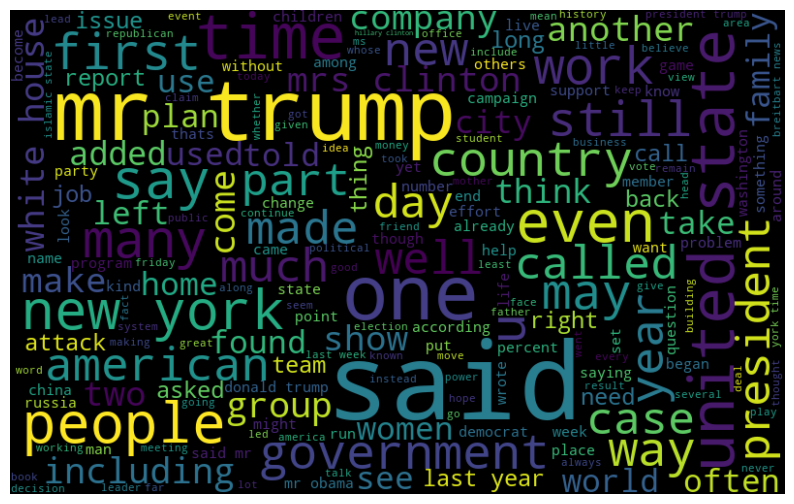

In [ ]:
#here all words has words from geninue_news(label=1)which are present in clean_news
all_words = ' '.join([text for text in df['clean_news'][df['label']==0]]) # Imagine you have a bunch of cleaned news articles in a column. This line of code takes all those
#articles, joins them together into one giant string, with a single space separating the words from different articles.
import wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

#### Visualizing fake news words

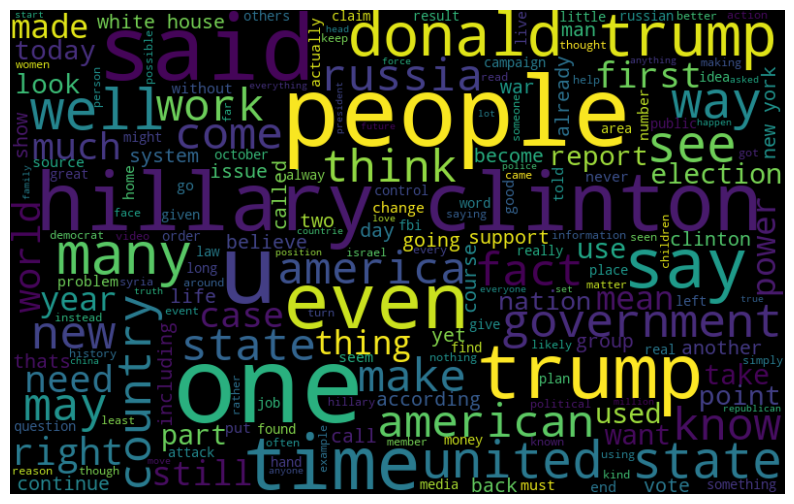

In [ ]:

all_words = ' '.join([text for text in df['clean_news'][df['label']==1]]) # Imagine you have a bunch of cleaned news articles in a column. This line of code takes all those
#articles, joins them together into one giant string, with a single space separating the words from different articles.
#here all words has words from fake_news(label=1)which are present in clean_news
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(all_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

## Creating Word Embeddings

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index # tokenizer.word_index is a dictionary.The keys of this dictionary are the unique words found in your text data.
#The values are assigned numerical indices representing each word.
vocab_size = len(word_index) # gives total unique words
vocab_size

187330

In [ ]:
# padding - some articles have 100 words some have 150 so to make each article of equal size we add pads i.e some 0s at the end
seqences = tokenizer.texts_to_sequences(df['clean_news']) #This line of code takes your cleaned news articles and replaces each word with its corresponding number from the dictionary.
# It then stores these numerical representations in a variable called seqences. This makes it possible for the deep learning model to work with the text data in a numerical format.
max_length = 500 # gives max length of biggest article from all articles
padded_seqences = pad_sequences(seqences,maxlen=max_length,padding='post',truncating='post') # will add padding on sequences after article i.e post and truncate article if above 700 words

In [ ]:
# Creating embedding Index
embeddings_index = {}
with open('glove.6B.100d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        embeddings_index[word] = coefs



In [ ]:
# Creating embedding matrix
embedding_matrix = np.zeros((vocab_size+1,100))
for word,i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(padded_seqences,df['label'],test_size=0.2,random_state=42,stratify=df['label'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout

model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      18,733,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,733,100 (71.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,733,100 (71.46 MB)

In [ ]:
history = model.fit(X_train,y_train,epochs=10,batch_size=256,validation_data=(X_test,y_test))

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6262 - loss: 0.6421 - val_accuracy: 0.6600 - val_loss: 0.5987
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6594 - loss: 0.6026 - val_accuracy: 0.6906 - val_loss: 0.5665
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6247 - loss: 0.6730 - val_accuracy: 0.6732 - val_loss: 0.5812
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6476 - loss: 0.6254 - val_accuracy: 0.6648 - val_loss: 0.5986
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6618 - loss: 0.5941 - val_accuracy: 0.6653 - val_loss: 0.5965
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6762 - loss: 0.5953 - val_accuracy: 0.6737 - val_loss: 0.5772
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6734 - loss: 0.5801 - val_accuracy: 0.7310 - val_loss: 0.5124
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.7912 - loss: 0.4548 - val_accuracy: 0.8550 - v

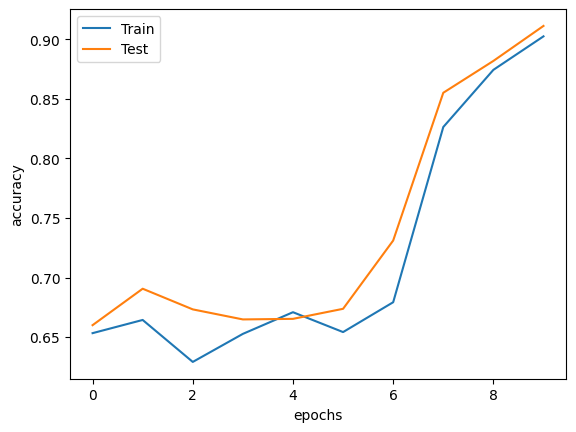

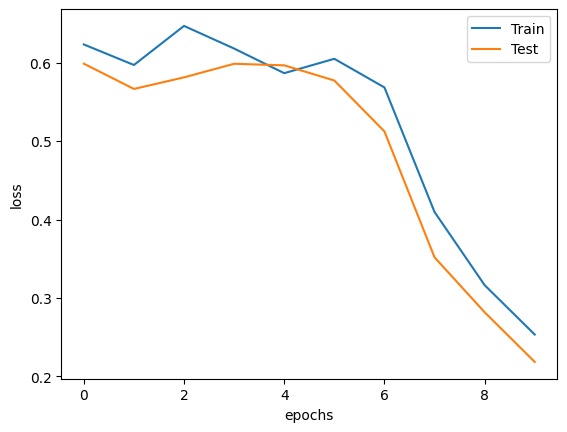

In [ ]:
# visualize the results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()